In [42]:
from funcs.notebook import *
from scipy.stats import kstest, uniform

# AU Mic only

In [44]:
aumic1 = pd.read_csv("../results/2021_02_18_AUMic_flares_1.csv")
aumic1 = aumic1[aumic1.final==1]
aumic27 = pd.read_csv("../results/2021_02_11_AUMic_flares_27.csv")
aumic27 = aumic27[aumic27.final==1]
aumic_ = pd.concat([aumic1,aumic27])


phases = []
for j, row in aumic.iterrows():
    try:
        lc = pd.read_csv(f"../results/observedtimes/AU Mic_{row.qcs}_0_TESS.csv")
        phases.append(lc.phase[np.argmin(np.abs(lc.time-row.tstart))])
    except Exception as e:
        print(e)
        phases.append(np.nan)

aumic_["phases"] = phases


In [54]:
aumic = aumic_.sort_values(by="ed_rec", ascending=False)

bins = np.linspace(0,1,2*aumic.shape[0])
# bins

aumicphases = pd.DataFrame()

for qcs in [1,27]:
    lc = pd.read_csv(f"../results/observedtimes/AU Mic_{qcs}_0_TESS.csv")
    counts, bins = np.histogram(lc.phase.values, bins=bins)
    aumicphases[qcs] = counts

# plt.bar((bins[:-1]+bins[1:]) / 2, 
#         aumicphases.sum(axis=1).values, 
#         width = bins[1]-bins[0],
#         facecolor="w", edgecolor="k")
# plt.xlim(0,1)



In [55]:
counts, bins = np.histogram(aumic.phases.values, bins=bins)
weighted = counts / aumicphases.sum(axis=1).values
weighted = weighted / weighted.sum()           
cumfreq = weighted.cumsum()

In [56]:
lin = np.linspace(cumfreq[0],np.max(cumfreq),len(bins)-1)

(0.0, 1.0)

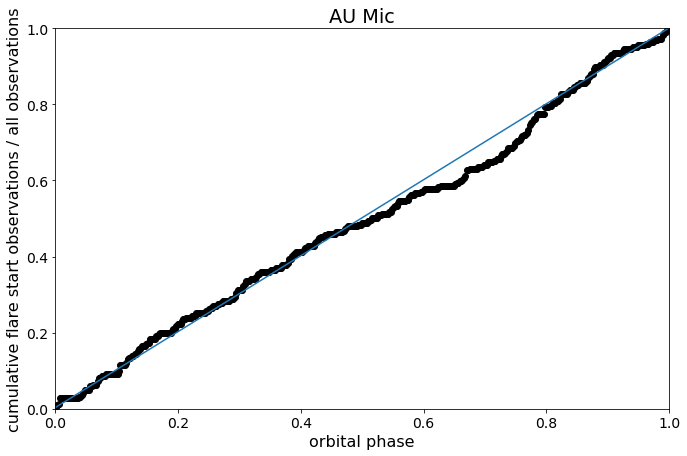

In [57]:
plt.figure(figsize=(11,7))
plt.scatter((bins[:-1]+bins[1:]) / 2,
             cumfreq, #(counts / aumicphases.sum(axis=1).values), 
            # yerr = np.sqrt(counts) / aumicphases.sum(axis=1).values,
             c='k')#,fmt="o")
plt.plot((bins[:-1]+bins[1:]) / 2,lin/cumfreq[-1])
plt.xlim(0,1)
plt.ylabel("cumulative flare start observations / all observations")
plt.xlabel("orbital phase")
plt.title("AU Mic")
plt.ylim(0,1)
# plt.savefig("../results/plots/AUMic_cumulative_flare_phases_27sec_only_57largest.png", dpi=300)

In [58]:
chi2 = []
for i in range(10000):
    expect = uniform.rvs(size=bins.shape[0]-1)
    expect = (expect/expect.sum()).cumsum()
    chi2.append(((np.linspace(expect[0],1,bins.shape[0]-1) - expect)**2 / expect).sum())
#     print(expect)

In [59]:
chi2re = ((np.linspace(cumfreq[0],1,bins.shape[0]-1) - cumfreq)**2 / cumfreq).sum()
chi2re

0.5920503565555895

In [60]:
np.percentile(chi2, np.linspace(80,100,20))

array([0.23383704, 0.24161423, 0.24941007, 0.25951258, 0.26831469,
       0.27715201, 0.28690718, 0.29991575, 0.31334754, 0.3261384 ,
       0.33792574, 0.356183  , 0.37269133, 0.39369238, 0.41895108,
       0.44933646, 0.48952003, 0.55433637, 0.68328905, 1.52608871])

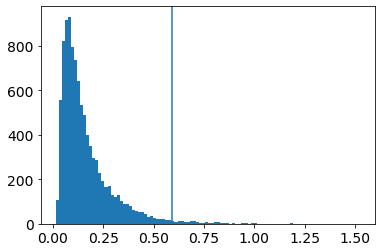

In [61]:
plt.hist(chi2, bins=100)
plt.axvline(chi2re)

In [62]:
kstest(cumfreq, uniform.cdf)

KstestResult(statistic=0.06840700254374821, pvalue=0.03440193676488623)

# Histograms

In [566]:
aumic1 = pd.read_csv("../results/2021_02_18_AUMic_flares_1.csv")
aumic27 = pd.read_csv("../results/2021_02_11_AUMic_flares_27.csv")
aumic = pd.concat([aumic1,aumic27])
aumic = aumic[aumic.final==1]

In [567]:
aumic.shape

(215, 20)

In [568]:
aumic = aumic.sort_values(by="ed_rec", ascending=True)#.iloc[:50]

In [569]:
from astropy.stats import poisson_conf_interval

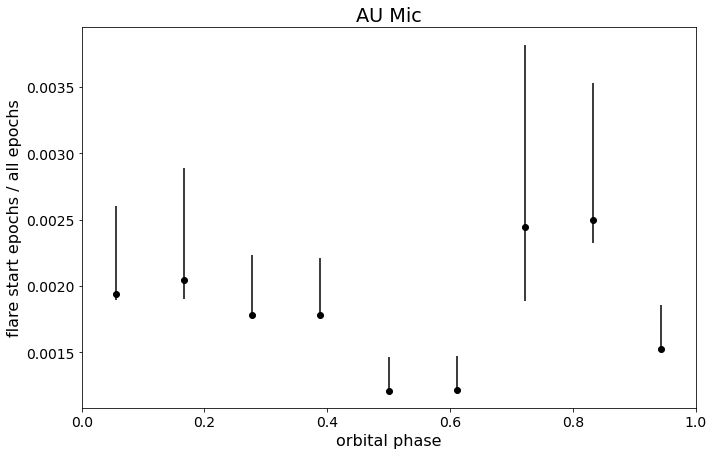

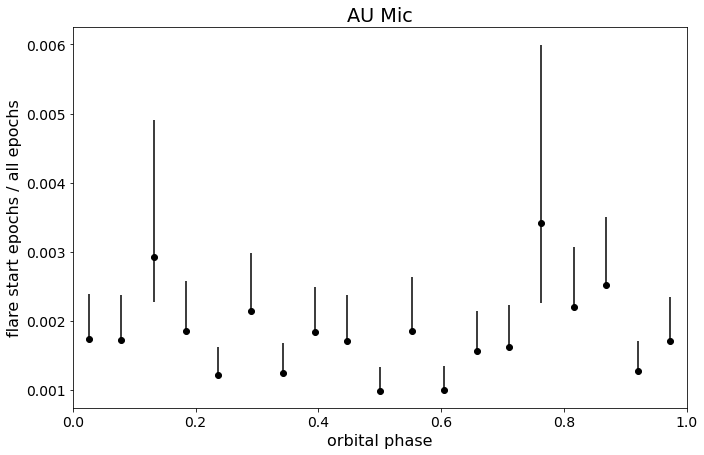

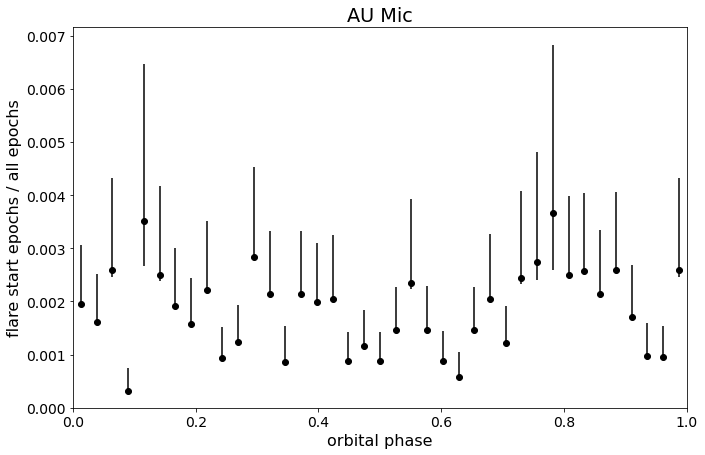

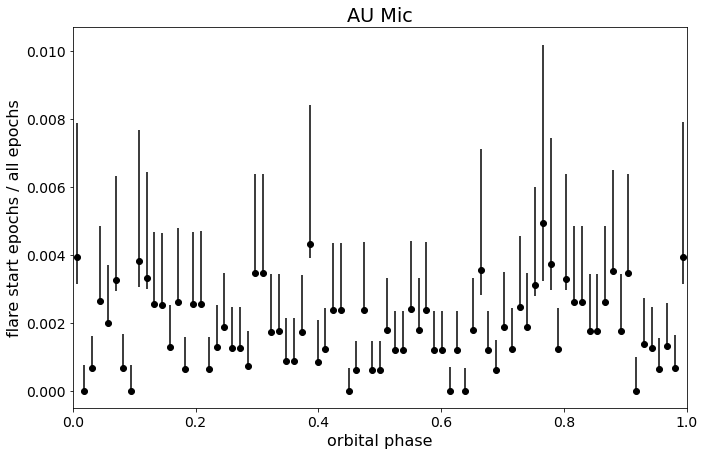

In [570]:
for b in [10,20,40, 80]:
    bins = np.linspace(0,1,b)
    aumicphases = pd.DataFrame()
    for qcs in [1,27]:
        lc = pd.read_csv(f"../results/observedtimes/AU Mic_{qcs}_0_TESS.csv")
        counts, bins = np.histogram(lc.phase.values, bins=bins)
        aumicphases[qcs] = counts
        
        
        
    phases = []
    for j, row in aumic.iterrows():
        try:
            lc = pd.read_csv(f"../results/observedtimes/AU Mic_{row.qcs}_0_TESS.csv")
            phases.append(lc.phase[np.argmin(np.abs(lc.time-row.tstart))])
        except Exception as e:
            print(e)
            phases.append(np.nan)  
            
    counts, bins = np.histogram(phases, bins=bins)

    plt.figure(figsize=(11,7))
    plt.errorbar((bins[:-1]+bins[1:]) / 2,
                 counts / aumicphases.sum(axis=1).values, 
                 yerr = poisson_conf_interval(counts, interval='kraft-burrows-nousek', confidence_level=0.68,
                                              background = counts.sum()/b)/ aumicphases.sum(axis=1).values,#np.sqrt(counts) / aumicphases.sum(axis=1).values,
                 c='k',fmt="o")
    # plt.plot((bins[:-1]+bins[1:]) / 2,lin)
    plt.xlim(0,1)
    plt.ylabel("flare start epochs / all epochs")
    plt.xlabel("orbital phase")
    plt.title("AU Mic")
    # plt.ylim(cumfreq[0],np.max(cumfreq))
#     plt.savefig(f"../results/plots/AUMic_flare_phases_{b}_bins_108_smallest.png", dpi=300)

In [571]:
counts.sum()

215

# Model

In [583]:
def gaussian(mu, sigma, res):
    
    x = np.linspace(0,1,res)
    gauss = lambda x: 1./(sigma * np.sqrt(2*np.pi))*np.exp(-np.power((x - mu)/sigma, 2.)/2)
    f1 = gauss(x)
    x = np.linspace(1,2,res)
    f2 = gauss(x)
    x = np.linspace(-1,0,res)
    f3 = gauss(x)
    return (f1 + f2 + f3)

def model(f, mu, sigma, N, obst):
    g = gaussian(mu, sigma, N) * f
    model = g + (1 - f)
    return model / obst

def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper



@logit
def uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate].

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    condition = ~(np.isfinite(maxrate) & np.isfinite(minrate))
    if ((maxrate < minrate) | condition):
        raise ValueError("maxrate must be > minrate, and a finite value")
    if ((rate >= minrate) & (rate <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0

    

@logit
def circular_uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate]. Values above

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    condition = ~(np.isfinite(maxrate) & np.isfinite(minrate))
    if ((maxrate < minrate) | condition):
        raise ValueError("maxrate must be > minrate, and a finite value")
        
    if rate < 0:
        rate -= np.floor(rate)
        
    if ((rate%1 >= minrate) & (rate%1 <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0    



def log_prior(params):

    """

    Parameters:


    """
    f, mu, sigma =  params
    
    prior = (uninformative_prior(f, 0, 1) + 
             uninformative_prior(mu, 0, 1) +  
             uninformative_prior(sigma, 0, 1)) 
    
    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)



def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp

    
def log_likelihood(params, N, freq, freq_err, obst):
    """structure of params:

    """
    f, mu, sigma =  params
    m = model(f, mu, sigma, N, obst)
    fr2 = freq_err**2
#     print(fr2)
    val = -0.5 * np.sum((freq - m) ** 2 / fr2 + np.log(fr2))

    return val


def log_probability(params, N, freq, freq_err, obst):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, N, freq, freq_err, obst)


In [572]:
aumic1 = pd.read_csv("../results/2021_02_18_AUMic_flares_1.csv")
aumic27 = pd.read_csv("../results/2021_02_11_AUMic_flares_27.csv")
aumic = pd.concat([aumic1,aumic27])
aumic = aumic[aumic.final==1]

In [573]:
aumic.shape

(215, 20)

In [574]:
bins = np.linspace(0,1,215)

In [575]:
aumicphases = pd.DataFrame()

In [576]:
for qcs in [1,27]:
    lc = pd.read_csv(f"../results/observedtimes/AU Mic_{qcs}_0_TESS.csv")
    counts, bins = np.histogram(lc.phase.values, bins=bins)
    aumicphases[qcs] = counts

(0.0, 1.0)

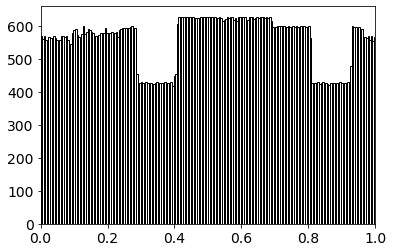

In [577]:
plt.bar((bins[:-1]+bins[1:]) / 2, 
        aumicphases.sum(axis=1).values, 
        width = bins[1]-bins[0],
        facecolor="w", edgecolor="k")
plt.xlim(0,1)

In [578]:
aumic_lower = aumic.sort_values(by="ed_rec", ascending=True).iloc[:107]
aumic_upper = aumic.sort_values(by="ed_rec", ascending=False).iloc[:108]

In [579]:
lower_phases, upper_phases, all_phases = [], [], []
for aumic, phases in [(aumic_lower, lower_phases),
                      (aumic_upper, upper_phases),
                      (aumic, all_phases)]:
    for j, row in aumic.iterrows():
        try:
            lc = pd.read_csv(f"../results/observedtimes/AU Mic_{row.qcs}_0_TESS.csv")
            phases.append(lc.phase[np.argmin(np.abs(lc.time-row.tstart))])
        except Exception as e:
            print(e)
            phases.append(np.nan)

In [580]:
counts, bins = np.histogram(all_phases, bins=bins)
freq = counts / aumicphases.sum(axis=1).values# * (len(bins)/len(all_phases))
freq_err = poisson_conf_interval(counts, interval='kraft-burrows-nousek', confidence_level=0.68,
                                              background = counts.sum()/b)/ aumicphases.sum(axis=1).values
# freq_err, freq

In [581]:
N = len(bins)-1
f = .1
mu = .77
sigma = 0.05
N

214

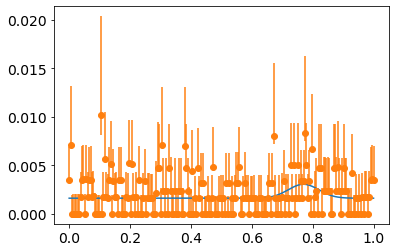

In [591]:
# plt.plot((bins[1:]+bins[:-1]) / 2, freq)
obst = aumicphases.sum(axis=1).values.mean()
m = model(f, mu, sigma, N, obst) 
plt.plot(np.linspace(0,1,N), m);
plt.errorbar(np.linspace(0,1,N), freq, yerr=freq_err, fmt="o");

In [589]:
import emcee

pos = np.array([f, mu, sigma]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(N, freq, freq_err, obst))
steps=200

In [590]:
sampler.run_mcmc(pos, steps, progress=True);

ValueError: Probability function returned NaN

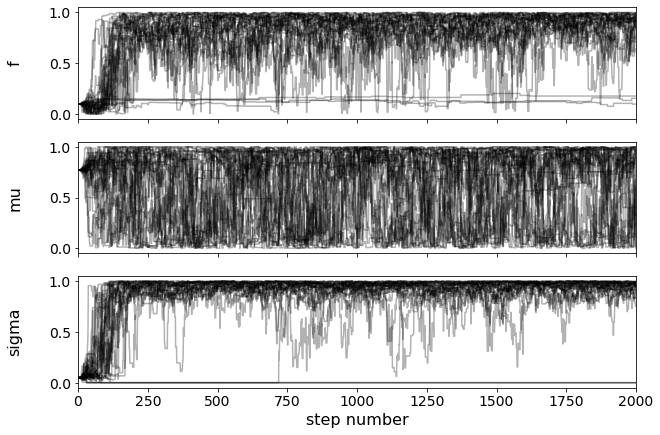

In [588]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["f", "mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [589]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)


(3200, 3)


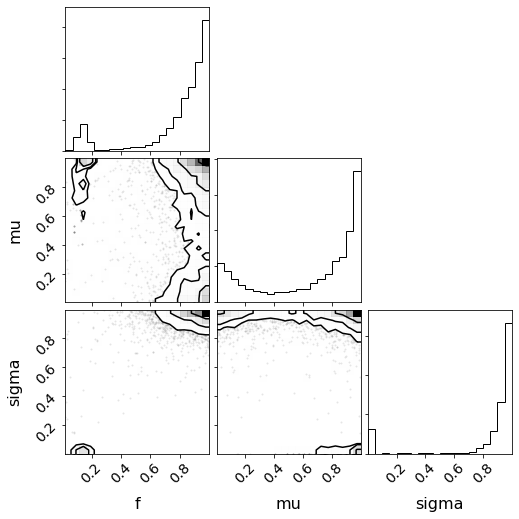

In [590]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[f, mu, sigma]
);
plt.savefig(f"../results/plots/model_mcmc_total_mcmc_{f}_{mu}_{sigma}_{N}_{steps}.png", dpi=300)

# Synthetic distributions

(0.0, 1.0)

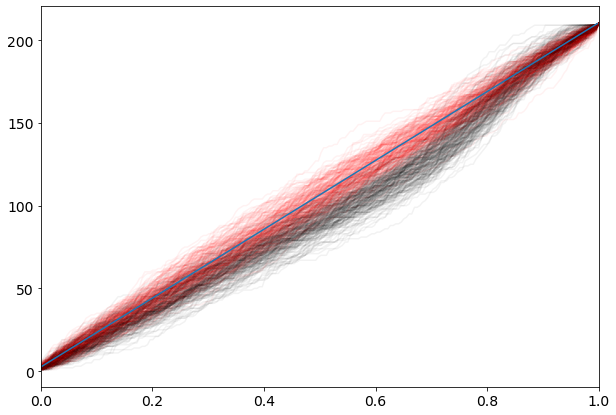

In [323]:
plt.figure(figsize=(10,7))
for i in range(0,200):

    # one with extra gauss
    random = np.random.rand(180)
    norm = np.random.normal(.8, .08, 30)

    norm[np.where(norm<0)] = 1 + norm[np.where(norm < 0)]

    both = np.append(random, norm)
    cumfreq  = np.histogram(both, bins=len(both))[0].cumsum()
    bins = np.linspace(0,1,len(both))
    lin = np.linspace(cumfreq[0],np.max(cumfreq),len(both)-1)
    plt.plot(bins, cumfreq, alpha=.05, c="k")
    
    # one only uniform
    
    random = np.random.rand(len(both))
    cumfreq  = np.histogram(random, bins=len(both))[0].cumsum()
    
    lin = np.linspace(cumfreq[0],np.max(cumfreq),len(both)-1)
    plt.plot(bins, cumfreq, alpha=.05, c="r")

    
    
    
    
plt.plot((bins[1:] + bins[:-1]) / 2., lin)
    
plt.xlim(0,1)
# plt.ylim(0, len(both))


In [335]:
N = 210
f = .1
mu = .8
sigma = 0.04
obst = 100
random = np.random.rand(int(np.rint(N * (1 - f))))
norm = np.random.normal(mu, sigma, int(np.rint(N * f)))

norm[np.where(norm<0)] = 1 + norm[np.where(norm < 0)]
norm[np.where(norm>1)] = -1 + norm[np.where(norm > 1)]

                        
both = np.append(random, norm)

counts, bins = np.histogram(both, bins=N)
freq_err = np.maximum(np.sqrt(counts), 1) / obst
freq = counts / obst

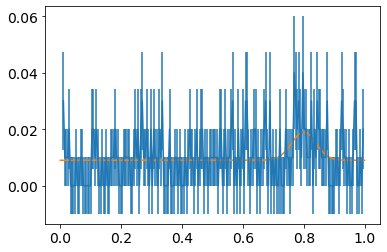

In [336]:
plt.errorbar((bins[1:]+bins[:-1]) / 2, freq, freq_err)
m = model(f, mu, sigma, N, obst)
plt.plot(np.linspace(0,1,N), m);

In [337]:
# log_likelihood([f, mu, sigma], N, counts, count_err)
log_probability([f, mu, sigma], N, freq, freq_err, obst)

888.2759331144086

In [338]:
import emcee

pos = np.array([f, mu, sigma]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(N, freq, freq_err, obst))
steps=20000

In [339]:
sampler.run_mcmc(pos, steps, progress=True);

100%|██████████| 20000/20000 [01:48<00:00, 183.91it/s]


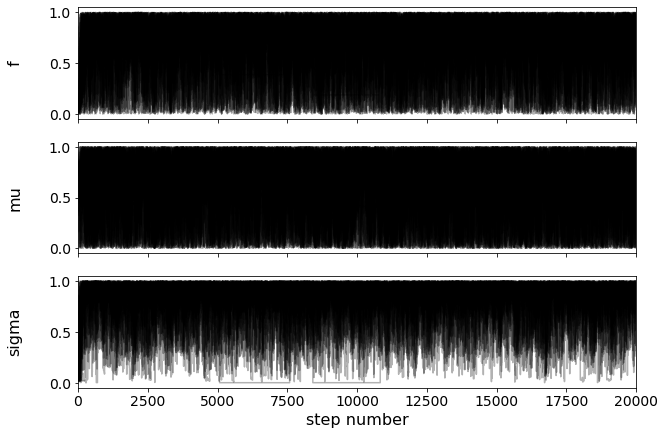

In [340]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["f", "mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [341]:
flat_samples = sampler.get_chain(discard=10000, thin=15, flat=True)
print(flat_samples.shape)


(21312, 3)


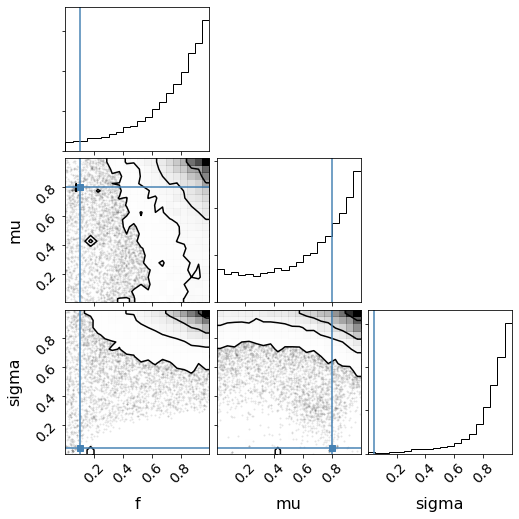

In [342]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[f, mu, sigma]
);
plt.savefig(f"../results/plots/model_mcmc_test_{f}_{mu}_{sigma}_{N}_{steps}.png", dpi=300)

In [555]:
1.4%1

0.3999999999999999

# Backlog